In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import networkx as nx
from collections import defaultdict
from scipy.optimize import minimize

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1.2
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'sans-serif'
cm_colors = plt.get_cmap('Set2')


In [3]:
def fit_eta(x, nqs, y_real):
    eta = x[0]
    y_eff = np.array([-eta*(nq - nqs[0]) for nq in nqs])
    return ((y_eff[:-1] - y_real[:-1])**2).mean() +  (y_eff[-1] - y_real[-1])**2

In [28]:
problems = ["WMaxcut", "PO", "MIS","3Maxcut"]
results = {problem: np.load(f"./Data/{problem}/results.npy", allow_pickle=True).item() for problem in problems}

averages = {}
for problem in problems:
    average = defaultdict(dict)
    for i, p in enumerate([10,25,50,100,200]):
        for nq in sorted(results[problem].keys()):
            y = [results[problem][nq][kk]["best"][p]["probabiliy"] for kk in results[problem][nq].keys()]
            quartiles = np.percentile(np.array(y), [25, 50, 75])
            average[p][nq] = quartiles[2]
    averages[problem] = average

np.save("./Data/Q3.npy", averages)

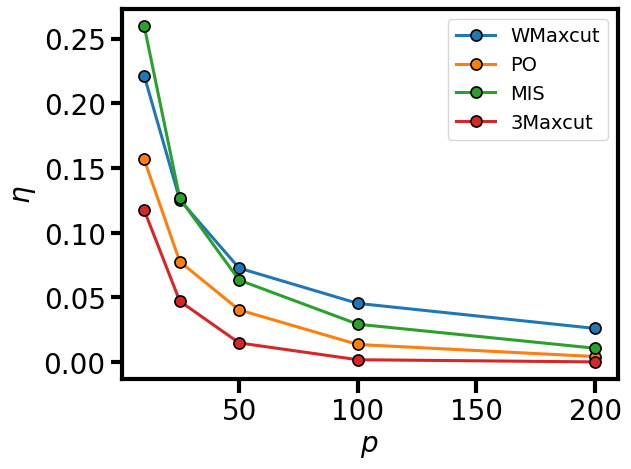

In [65]:
averages = np.load("./Data/averages.npy", allow_pickle=True).item()
colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]

fig, ax = plt.subplots()
for problem in averages.keys():
    etas = {}
    error = {}
    sort = averages[problem]
    for p in ps:
        nqs = list(averages[problem][p].keys())
        y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
        x0 = [0.25]
        sol = minimize(fit_eta, x0, args=(nqs, y_real))
        etas[p] = sol.x[0]
        error[p] = sol.fun

    ax.plot(sorted(ps), [etas[p] for p in sorted(ps)], marker="o", markersize=8, markeredgecolor="black", label=problem)
    ax.set_ylabel(r"$\eta$")
    ax.set_xlabel(r"$p$")
ax.legend()
# ax.set_yscale("log")
fig.savefig("./Figures/etas.pdf", transparent=True, bbox_inches="tight")

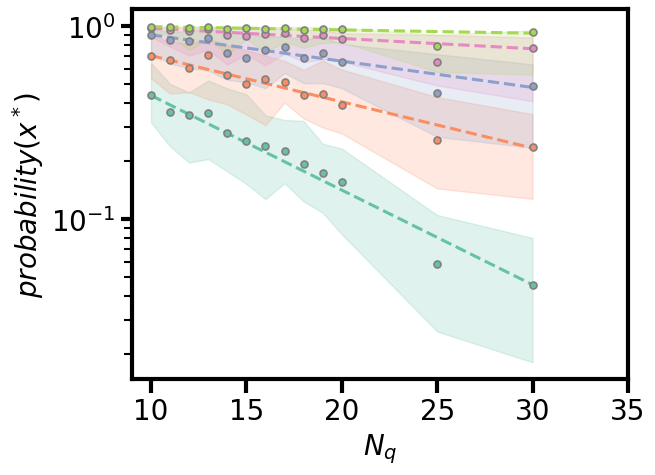

In [5]:
problem_name = "PO"
colors = plt.get_cmap("Set2")
sort = np.load("./Data/averages.npy", allow_pickle=True).item()[problem_name]
Q1 = np.load("./Data/Q1.npy", allow_pickle=True).item()[problem_name]
Q3 = np.load("./Data/Q3.npy", allow_pickle=True).item()[problem_name]
min_q = 10
ps = [10,25,50,100,200]
etas = {}
error = {}
for p in ps:
    nqs = [q for q in list(sort[p].keys()) if q >= min_q]
    y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
    x0 = [0.25]
    sol = minimize(fit_eta, x0, args=(nqs, y_real))
    etas[p] = sol.x[0]
    error[p] = sol.fun

ps = [10,25,50,100,200]
fig, ax = plt.subplots()
for i, p in enumerate(sort.keys()):
    nqs = [q for q in list(sort[p].keys()) if q >= min_q]
    ax.plot(nqs, [sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0])) for nq in nqs], linestyle="--", color=colors(i))
    ax.plot(nqs, [sort[p][nq] for nq in nqs], marker="o", linewidth=0, color=colors(i), markeredgecolor="gray")

    ax.fill_between(nqs, [Q1[p][nq] for nq in nqs], [Q3[p][nq] for nq in nqs], alpha=0.2, color=colors(i))
    # ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[ps[0]]*(nq - nqs[0])) for nq in nqs], linestyle=":", color=colors(i))

ax.set_yscale("log")
ax.set_ylabel(r"$probability(x^*)$")
ax.set_xlabel(r"$N_q$")
ax.set_xticks([10, 15,20,25,30,35])
fig.savefig(f"./Figures/{problem_name}_scale.pdf")
# ax[0].set_yscale("log")
# ax[0].set_ylim(0,10)